# Projet Speed Dating (Tinder)

## Compréhension du contexte des données

La lecture du document [Dataset Description](https://full-stack-assets.s3.eu-west-3.amazonaws.com/M03-EDA/Speed+Dating+Data+Key.doc) permet de mieux comprendre les colonnes que nous allons trouver dans le dataset.

Lors de chaque événement de speed dating, les candidats se sont vu proposer plusieurs questionnaires, à plusieurs étapes du processus:
- lors de l'inscription: information personnelles et attentes quant aux attributs des partenaires à rencontrer
- aprés chaque rencontre: notes sur les attributs du partenaire rencontré
- au milieu de l'évènement: ré-évaluation des attentes du candidat et de sa perception de lui-même
- le lendemain de l'évènement: avis sur l'event, notation des attributs selon différentes perspectives
- 3 à 4 semaines aprés l'évènement: suivi des matchs, notation des attributs selon différentes perspectives

Le candidat est amené à plusieur reprises et selon différentes perspective à noter les attributs suivant:
- attractivité (attr: Attractive)
- sincérité (sinc: Sincere)
- intelligence (intel: Intelligent)
- amusement (fun: Fun)
- ambition (amb: Ambitious)
- intérêts communs (shar: Shared Interests/Hobbies)

Perspectives à prendre (selon le moment du questionnaire) lors de la notation:
- Ce que est important pour vous chez un partenaire
- Perception de ce que la plupart des personnes du même sexe recherchent
- Perception de ce que le sexe opposé recherche
- Auto-évaluation (comment le candidat se perçoit)
- Évaluation du partenaire rencontré
- Perception de comment les autres vous perçoivent
- Importance réelle dans les décisions

Tous ces éléments se retrouvent encodés dans les libellés des paramètres concernés (attr, sinc, intel, fun, amb, shar).
Libellé: `attrib{P}_{T}`
- `{P}`: la perspective, la contexte pour la notation
- `{T}`: à quel moment le questionnaire a été rempli

Chronologie:

| Moment | T |
| --- | --- |
| lors de l'inscription  | 1 |
| aprés chaque rencontre | blank label, no suffix |
| au milieu de l'évènement | s |
| le lendemain de l'évènement | 2  |
| 3 à 4 semaines aprés l'évènement | 3 |

Perpesctive de la notation:

| Perspective | P |
| --- | --- |
| Ce que est important pour vous chez un partenaire | 1 |
| Perception de ce que le sexe opposé recherche | 2 |
| Auto-évaluation (comment le candidat se perçoit) | 3 |
| Perception de ce que la plupart des personnes du même sexe recherchent | 4 |
| Perception de comment les autres vous perçoivent | 5 |
| Évaluation du partenaire rencontré | blank label, no suffix |
| Importance réelle dans les décisions | 7 |

Disponibilité de perpesctive des attributs en fonction de la chronologie:

| Perspective | lors de l'inscription | aprés chaque rencontre | au milieu de l'évènement |  le lendemain | 3 à 4 semaines aprés |
| --- | --- | --- | --- | --- | --- |
| Ce que est important pour vous chez un partenaire | x (1_1) |  | x (1_s) | x (1_2) | x (1_3) |
| Perception de ce que le sexe opposé recherche | x (2_1) |  |  | x (2_2) | x (2_3) |
| Auto-évaluation (comment le candidat se perçoit) | x (3_1) |  | x (3_s) | x (3_2) | x (3_3) |
| Perception de ce que la plupart des personnes du même sexe recherchent | x (4_1) |  |  | x (4_2) | x (4_3) |
| Perception de comment les autres vous perçoivent | x (5_1) |  |  | x (5_2) | x (5_3) |
| Évaluation du partenaire rencontré |  | x |  |  |  |
| Importance réelle dans les décisions |  |  |  | x (7_2) | x (7_3) |

### Les vagues: évenement de speed-dating
Il est a noté que selon les vagues toutes les données ne seront pas forcément disponibles ou n'auront pas le même format de notation.
Au sein d'une même vague on peut aussi avoir des mécanisme de notation différent d'un temps à l'autre.

On peut notamment avoir des attributs notés de 1 à 10 pour les vagues 6 à 9 alors que le candidat doit répartir un total de 100 points sur l'ensemble de ceux-ci pour les vagues 1 à 5 et 10 à 21.

**attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1**:
- Waves 6-9: scale of 1-10 (1=not at all important, 10=extremely important)
- Waves 1-5, 10-21: You have 100 points to distribute (give more points to those attributes that are more important)

**attr4_1, sinc4_1, intel4_1, fun4_1, amb4_1, shar4_1**:
- Waves 6-9: scale of 1-10 (1=not at all important, 10=extremely important)
- Waves 10-21: You have 100 points to distribute (give more points to those attributes that are more important)
- No waves 1-5

**attr2_1, sinc2_1, int2_1, fun2_1, amb2_1, shar2_1**:
- Waves 6-9: scale of 1-10 (1=not at all important, 10=extremely important)
- Waves 1-5, 10-21: You have 100 points to distribute (give more points to those attributes that are more important)

**attr1_2, sinc1_2, intel1_2, fun1_2, amb1_2, shar1_2**:
- Waves 6-9: scale of 1-10 (1=not at all important, 10=extremely important)
- Waves 1-5, 10-21: You have 100 points to distribute (give more points to those attributes that are more important)


On notera également que certaines perspectives ne sont pas disponbles sur certaines vagues (exemple: perception de ce que la plupart des personnes du même sexe recherchent sur les vagues 6 à 21 seulement).

Toutes ces inconsistences ne rendent pas l'exploitation aisée.

### Target

La variable qui nous intéresse est la colonne `match` indiquant si deux candidats se sont réciproquement choisis lors de leur tour durant le speed-dating. 

## Import de modules externes

In [124]:
import re

import requests
import pandas as pd
# import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from skimpy import skim
import missingno as msno

from speed_dating_document_context import (
    all_documented_columns,
    pref_1_1_cols,
    pref_4_1_cols,
    pref_2_1_cols,
    pref_1_2_cols
)

from config import (
    JEDHA_SPEED_DATING_DATA_EXPLANATIONS_URL,
    LOCAL_SPEED_DATING_DATA_EXPLANATIONS_PATH,
    JEDHA_SPEED_DATING_CSV_URL,
    LOCAL_SPEED_DATING_CSV_PATH,
)

# display settings
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', 1000)          # Expand display width
pd.set_option('display.max_colwidth', None)   # Show full content in each cell

In [125]:
# Retrive locally explanation document
if not LOCAL_SPEED_DATING_DATA_EXPLANATIONS_PATH.exists():
    response = requests.get(JEDHA_SPEED_DATING_DATA_EXPLANATIONS_URL)

    with open(LOCAL_SPEED_DATING_DATA_EXPLANATIONS_PATH, mode="wb") as file:
        file.write(response.content)

## Chargement des données

In [126]:
if not LOCAL_SPEED_DATING_CSV_PATH.exists():
    response = requests.get(JEDHA_SPEED_DATING_CSV_URL)

    with open(LOCAL_SPEED_DATING_CSV_PATH, mode="wb") as file:
        file.write(response.content)

# Loading DataFrame
speed_dating_df = pd.read_csv(LOCAL_SPEED_DATING_CSV_PATH, encoding="ISO-8859-1")

## Exploration initiale
### Vérifications basiques
- Shape
- Types
- Description

In [127]:
print("Shape:")
lines, columns = speed_dating_df.shape
print(f"- {columns} colonnes")
print(f"- {lines} lignes")

# Contextual stats
print("Number of participants: {}".format(len(speed_dating_df["iid"].unique())))
print()


Shape:
- 195 colonnes
- 8378 lignes
Number of participants: 551



In [128]:
# Gender balance

gender_df = speed_dating_df.drop_duplicates("iid")["gender"].map({0:'Woman',1:'Man'}).reset_index()
gender_df.groupby("gender").count()

,index
gender,
Man,277
Woman,274


277 hommes et 274 femmes : l'équilibre est bien respecté.

In [129]:
# parité par vague
all_waves_df = speed_dating_df[["iid", "wave", "gender"]].drop_duplicates()
all_waves_df["gender_label"] = all_waves_df["gender"].map({0:'Woman',1:'Man'})

all_waves_df = all_waves_df.groupby(["wave", "gender_label"])["iid"].count()

all_waves_df = all_waves_df.unstack()
all_waves_df["parity"] = all_waves_df["Man"] == all_waves_df["Woman"]

display(all_waves_df)

gender_label,Man,Woman,parity
wave,,,
1,10,10,True
2,16,19,False
3,10,10,True
4,18,18,True
5,10,9,False
6,5,5,True
7,16,16,True
8,10,10,True
9,20,20,True


Toutes les vagues n'ont pas le même nombres d'hommes et de femmes. Certains auront donc plus de meeting (round) que d'autres.

In [130]:
# Display Index, Columns, and Data
speed_dating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


In [131]:
print("Head:")
display(speed_dating_df.head())

print("Tail:")
display(speed_dating_df.tail())

Head:


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9

Tail:


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
8373,552,22.0,1,44,2,21,22,14,10.0,5,18,526.0,0,0.64,0,26.0,3.0,10.0,10.0,30.0,20.0,10.0,15.0,1,10.0,5.0,3.0,2.0,6.0,5.0,6.0,1.0,NaN,25.0,Climate Dynamics,18.0,"Ecole Normale Suprieure, Paris",NaN,NaN,2.0,1.0,1.0,France,"78,110",NaN,1.0,2.0,1.0,assistant master of the universe (otherwise it's too much work),15.0,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,NaN,70.0,0.0,15.0,15.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,10.0,50.0,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0,0,3.0,5.0,5.0,5.0,NaN,NaN,2.0,5.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,2.0,70.0,0.0,15.0,10.0,0.0,5.0,70.0,0.0,15.0,10.0,0.0,5.0,80.0,0.0,5.0,5.0,0.0,10.0,50.0,5.0,10.0,20.0,5.0,10.0,9.0,3.0,7.0,6.0,9.0,9.0,3.0,9.0,4.0,7.0,2.0,0.0,0.0,NaN,1.0,70.0,0.0,20.0,10.0,0.0,0.0,70.0,0.0,20.0,10.0,0.0,0.0,80.0,0.0,10.0,0.0,0.0,10.0,50.0,5.0,10.0,20.0,10.0,5.0,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,19,527.0,0,0.71,0,24.0,6.0,50.0,20.0,10.0,5.0,10.0,5.0,0,6.0,3.0,7.0,3.0,7.0,2.0,2.0,2.0,2.0,25.0,Climate Dynamics,18.0,"Ecole Normale Suprieure, Paris",NaN,NaN,2.0,1.0,1.0,France,"78,110",NaN,1.0,2.0,1.0,assistant master of the universe (otherwise it's too much work),15.0,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,NaN,70.0,0.0,15.0,15.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,10.0,50.0,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0,0,4.0,6.0,8.0,4.0,4.0,NaN,4.0,4.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,2.0,70.0,0.0,15.0,10.0,0.0,5.0,70.0,0.0,15.0,10.0,0.0,5.0,80.0,0.0,5.0,5.0,0.0,10.0,50.0,5.0,10.0,20.0,5.0,10.0,9.0,3.0,7.0,6.0,9.0,9.0,3.0,9.0,4.0,7.0,2.0,0.0,0.0,NaN,1.0,70.0,0.0,20.0,10.0,0.0,0.0,70.0,0.0,20.0,10.0,0.0,0.0,80.0,0.0,10.0,0.0,0.0,10.0,50.0,5.0,10.0,20.0,10.0,5.0,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,20,528.0,0,-0.46,0,29.0,3.0,40.0,10.0,30.0,10.0,10.0,NaN,0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,25.0,Climate Dynamics,18.0,"Ecole Normale Suprieure, Paris",NaN,NaN,2.0,1.0,1.0,France,"78,110",NaN,1.0,2.0,1.0,assistant master of the universe (otherwise it's too much work),15.0,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,NaN,70.0,0.0,15.0,15.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,10.0,50.0,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0,0,4.0,7.0,8.0,8.0,8.0,NaN,6.0,5.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,2.0,70.0,0.0,15.0,10.0,0.0,5.0,70.0,0.0,15.0,10.0,0.0,5.0,80.0,0.0,5.0,5.0,0.0

In [132]:
all_csv_columns = speed_dating_df.columns
# ["iid","id","gender","idg","condtn","wave","round","position","positin1","order","partner","pid","match","int_corr","samerace","age_o","race_o","pf_o_att","pf_o_sin","pf_o_int","pf_o_fun","pf_o_amb","pf_o_sha","dec_o","attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o","like_o","prob_o","met_o","age","field","field_cd","undergra","mn_sat","tuition","race","imprace","imprelig","from","zipcode","income","goal","date","go_out","career","career_c","sports","tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv","theater","movies","concerts","music","shopping","yoga","exphappy","expnum","attr1_1","sinc1_1","intel1_1","fun1_1","amb1_1","shar1_1","attr4_1","sinc4_1","intel4_1","fun4_1","amb4_1","shar4_1","attr2_1","sinc2_1","intel2_1","fun2_1","amb2_1","shar2_1","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1","attr5_1","sinc5_1","intel5_1","fun5_1","amb5_1","dec","attr","sinc","intel","fun","amb","shar","like","prob","met","match_es","attr1_s","sinc1_s","intel1_s","fun1_s","amb1_s","shar1_s","attr3_s","sinc3_s","intel3_s","fun3_s","amb3_s","satis_2","length","numdat_2","attr7_2","sinc7_2","intel7_2","fun7_2","amb7_2","shar7_2","attr1_2","sinc1_2","intel1_2","fun1_2","amb1_2","shar1_2","attr4_2","sinc4_2","intel4_2","fun4_2","amb4_2","shar4_2","attr2_2","sinc2_2","intel2_2","fun2_2","amb2_2","shar2_2","attr3_2","sinc3_2","intel3_2","fun3_2","amb3_2","attr5_2","sinc5_2","intel5_2","fun5_2","amb5_2","you_call","them_cal","date_3","numdat_3","num_in_3","attr1_3","sinc1_3","intel1_3","fun1_3","amb1_3","shar1_3","attr7_3","sinc7_3","intel7_3","fun7_3","amb7_3","shar7_3","attr4_3","sinc4_3","intel4_3","fun4_3","amb4_3","shar4_3","attr2_3","sinc2_3","intel2_3","fun2_3","amb2_3","shar2_3","attr3_3","sinc3_3","intel3_3","fun3_3","amb3_3","attr5_3","sinc5_3","intel5_3","fun5_3","amb5_3"]

# Comparaison des colonnes doc vs csv
print(f"Documented columns: {len(all_documented_columns)}")
print(f"CSV columns: {len(all_csv_columns)}")

doc_col_in_csv = 0

for doc_col in all_documented_columns:
    if doc_col in all_csv_columns:
        doc_col_in_csv += 1
        
print(f"Document columns in CSV: {doc_col_in_csv}")

Documented columns: 195
CSV columns: 195
Document columns in CSV: 195


In [133]:
# Display Data Types
display(speed_dating_df.dtypes)

iid           int64
id          float64
gender        int64
idg           int64
condtn        int64
             ...   
attr5_3     float64
sinc5_3     float64
intel5_3    float64
fun5_3      float64
amb5_3      float64
Length: 195, dtype: object

In [134]:
# Summary Statistics
speed_dating_df.describe(include='all')

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
count,8378.000000,8377.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,6532.000000,8378.000000,8378.000000,8368.000000,8378.000000,8220.000000,8378.000000,8274.000000,8305.000000,8289.000000,8289.000000,8289.000000,8280.000000,8271.000000,8249.000000,8378.000000,8166.000000,8091.000000,8072.000000,8018.000000,7656.000000,7302.000000,8128.000000,8060.000000,7993.000000,8283.000000,8315,8296.000000,4914,3133,3583,8315.000000,8299.000000,8299.000000,8299,7314,4279,8299.000000,8281.000000,8299.000000,8289,8240.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8277.000000,1800.000000,8299.000000,8299.000000,8299.000000,8289.000000,8279.000000,8257.000000,6489.000000,6489.000000,6489.000000,6489.000000,6489.000000,6467.000000,8299.000000,8299.000000,8299.000000,8299.000000,8289.000000,8289.000000,8273.000000,8273.000000,8273.000000,8273.000000,8273.000000,4906.000000,4906.000000,4906.000000,4906.000000,4906.000000,8378.000000,8176.000000,8101.000000,8082.000000,8028.000000,7666.000000,7311.000000,8138.000000,8069.000000,8003.000000,7205.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,7463.000000,7463.000000,7433.000000,1984.000000,1955.000000,1984.000000,1984.000000,1955.000000,1974.000000,7445.000000,7463.000000,7463.000000,7463.000000,7463.000000,7463.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.00000,5775.000000,5775.000000,5775.000000,5775.000000,7463.000000,7463.000000,7463.000000,7463.000000,7463.000000,4377.000000,4377.000000,4377.000000,4377.000000,4377.000000,3974.000000,3974.000000,3974.000000,1496.000000,668.000000,3974.000000,3974.000000,3974.000000,3974.000000,3974.000000,3974.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2959.000000,2016.000000,3974.000000,3974.000000,3974.000000,3974.000000,3974.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259,NaN,241,68,115,NaN,NaN,NaN,269,409,261,NaN,NaN,NaN,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Few abnormal maximum values:
- attr_o: max 10.5
- fun_o: max 11
- gaming: max 14
- reading: max 13

In [135]:
skim(speed_dating_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 8378   │ │ float64     │ 174   │                                                          │
│ │ Number of columns │ 195    │ │ int64       │ 13    │                                                          │
│ └───────────────────┴────────┘ │ string      │ 8     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column    ┃ NA    ┃ NA %                ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ iid       │     0 │                   0 │  283.7 │  158.6 │     1 │   154 │   281 │   407 │   552 │ ▇▆█▇▇█ │  │
│ │ id        │     1 │   0.011936022917164 │   8.96 │  5.491 │     1 │     4 │     8 │    13 │    22 │ █▆▇▄▄▂ │  │
│ │ gender    │     0 │                   0 │ 0.5006 │    0.5 │     0 │     0 │     1 │     1 │     1 │ █    █ │  │
│ │ idg       │     0 │                   0 │  17.33 │  10.94 │     1 │     8 │    16 │    26 │    44 │ █▇▆▅▄▂ │  │
│ │ condtn    │     0 │                   0 │  1.829 │ 0.3767 │     1 │     2 │     2 │     2 │     2 │ ▂    █ │  │
│ │ wave      │     0 │                   0 │  11.35 │  5.996 │     1 │     7 │    11 │    15 │    21 │ ▆▃▄█▄▆ │  │
│ │ round     │     0 │                   0 │  16.87 │  4.358 │     5 │    14 │    18 │    20 │    22 │ ▁▃ ▅▅█ │  │
│ │ position  │     0 │                   0 │  9.043 │  5.515 │     1 │     4 │     8 │    13 │    22 │ █▆▇▄▄▂ │  │
│ │ positin1  │  1846 │  22.033898305084747 │  9.296 │   5.65 │     1 │     4 │     9 │    14 │    22 │ █▆▇▄▄▂ │  │
│ │ order     │     0 │                   0 │  8.928 │  5.477 │     1 │     4 │     8 │    13 │    22 │ █▆▇▄▄▂ │  │
│ │ partner   │     0 │                   0 │  8.964 │  5.491 │     1 │     4 │     8 │    13 │    22 │ █▆▇▄▄▂ │  │
│ │ pid       │    10 │    0.11936022917164 │  283.9 │  158.6 │     1 │   154 │   281 │   408 │   552 │ ▇▆█▇▇█ │  │
│ │ match     │     0 │                   0 │ 0.1647 │ 0.3709 │     0 │     0 │     0 │     0 │     1 │ █    ▂ │  │
│ │ int_corr  │   158 │   1.885891620911912 │  0.196 │ 0.3035 │ -0.83 │ -0.02 │  0.21 │  0.43 │  0.91 │  ▂▅█▇▂ │  │
│ │ samerace  │     0 │                   0 │ 0.3958 │ 0.4891 │     0 │     0 │     0 │     1 │     1 │ █    ▅ │  │
│ │ age_o     │   104 │  1.2413463833850562 │  26.36 │  3.564 │    18 │    24 │    26 │    28 │    55 │  ▅█▁   │  │
│ │ race_o    │    73 │   0.871329672952972 │  2.757 │  1.231 │     1 │     2 │     2 │     4 │     6 │ ▁█▁▃ ▁ │  │
│ │ pf_o_att  │    89 │   1.062306039627596 │   22.5 │  12.57 │     0 │    15 │    20 │    25 │   100 │  ▅█▁▁  │  │
│ │ pf_o_sin  │    89 │   1.062306039627596 │   17.4 │  7.044 │     0 │    15 │ 18.37 │    20 │    60 │  ▁█▇▁  │  │
│ │ pf_o_int  │    89 │   1.062306039627596 │  20.27 │  6.783 │     0 │ 17.39 │    20 │ 23.81 │    50 │   ▃█▃  │  │
│ │ pf_o_fun  │    98 │  1.1697302458820722 │  17.46 │  6.086 │     0 │    15 │    18 │    20 │    50 │  ▁▆█▂  │  │
│ │ pf_o_amb  │   107 │   1.277154452136548 │  10.69 │  

### Valeurs manquantes

<Axes: >

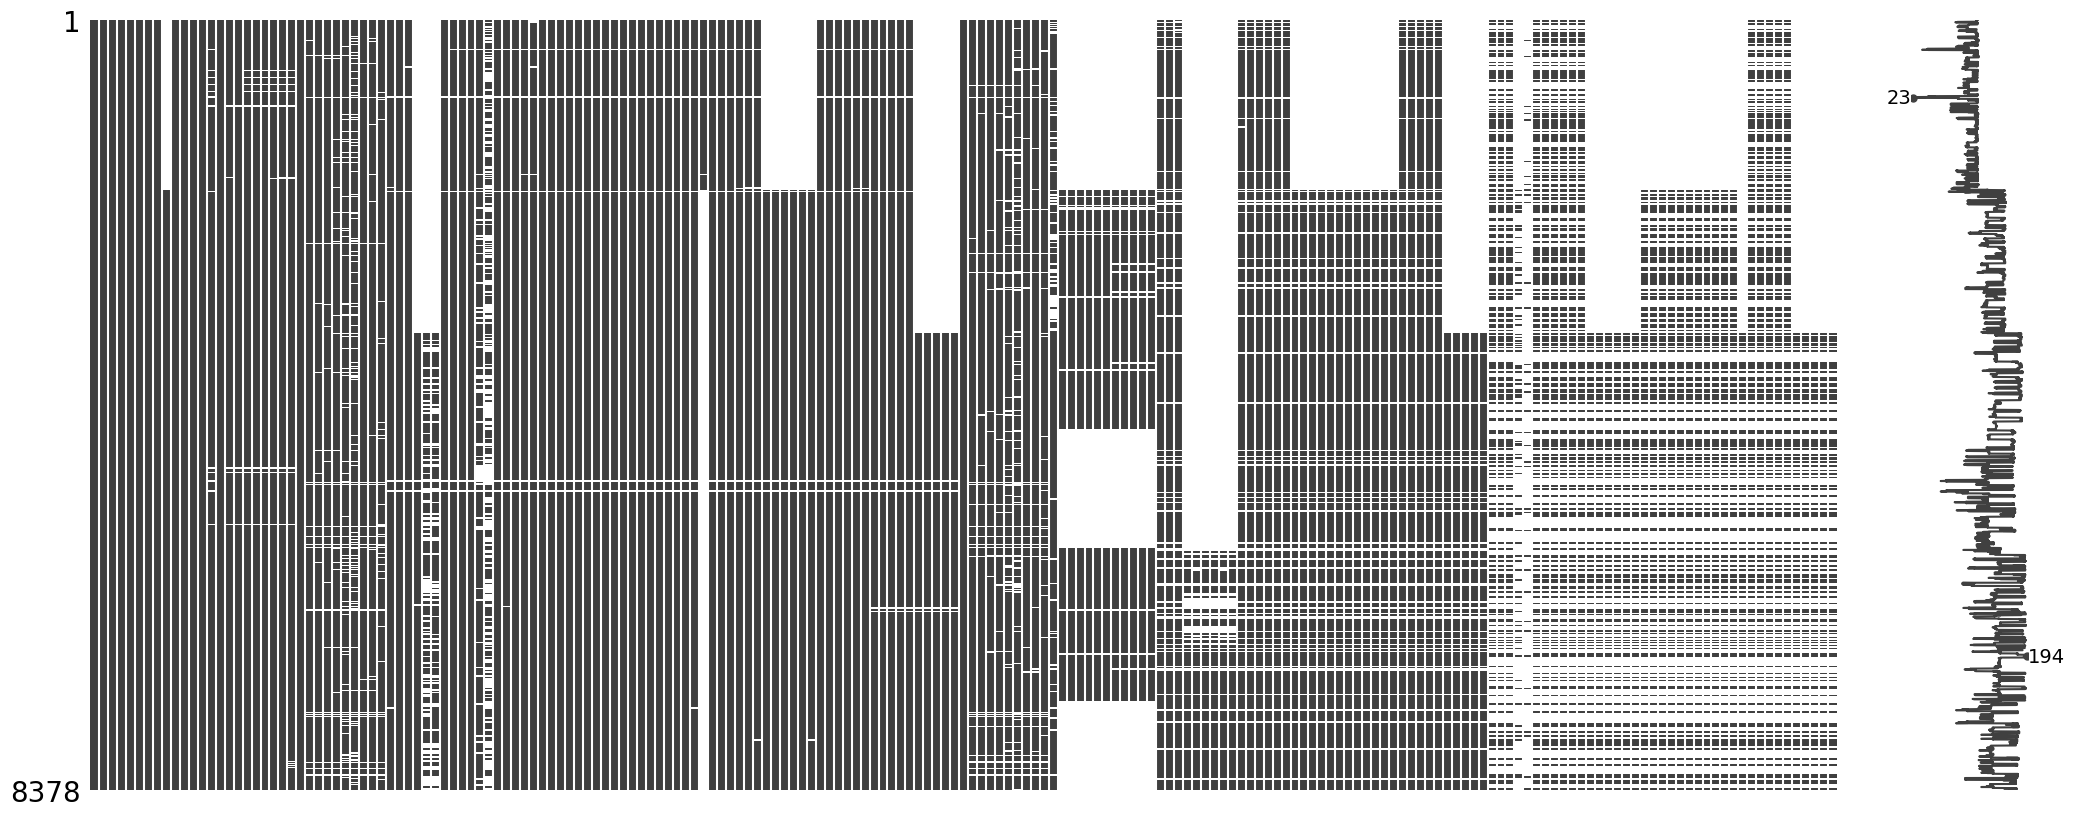

In [136]:
# N/A visualization
msno.matrix(speed_dating_df, labels=False)

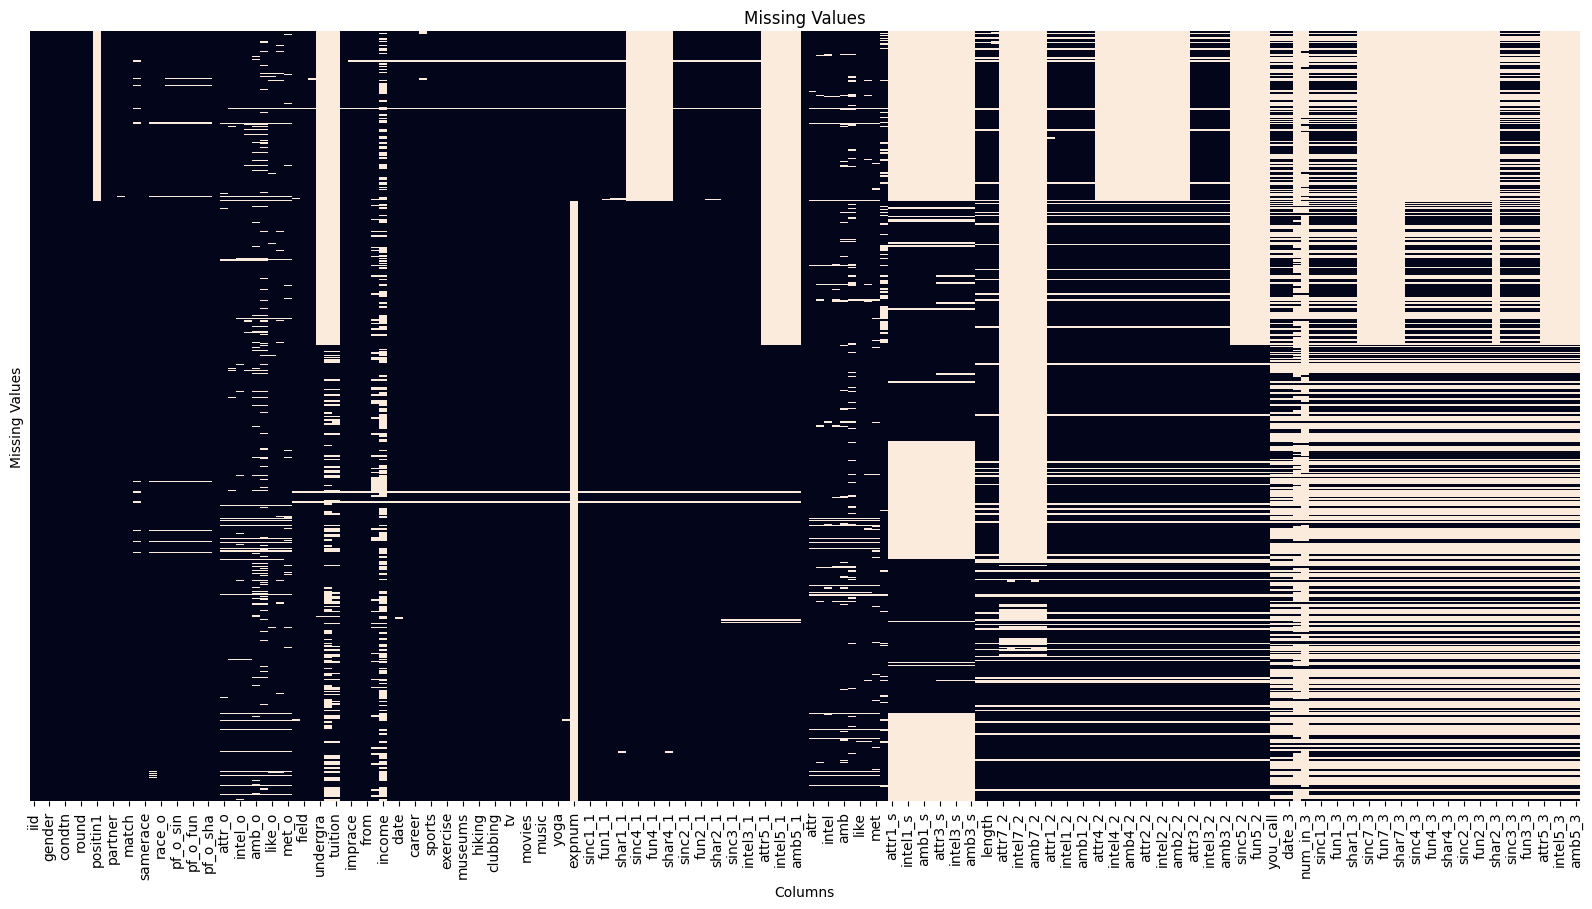

In [137]:
fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(speed_dating_df.isna(), yticklabels = False, cbar=False, ax=ax)

plt.title("Missing Values", fontsize=12)
plt.xlabel("Columns", fontsize = 10) 
plt.ylabel("Missing Values", fontsize = 10)

plt.show()


<Axes: >

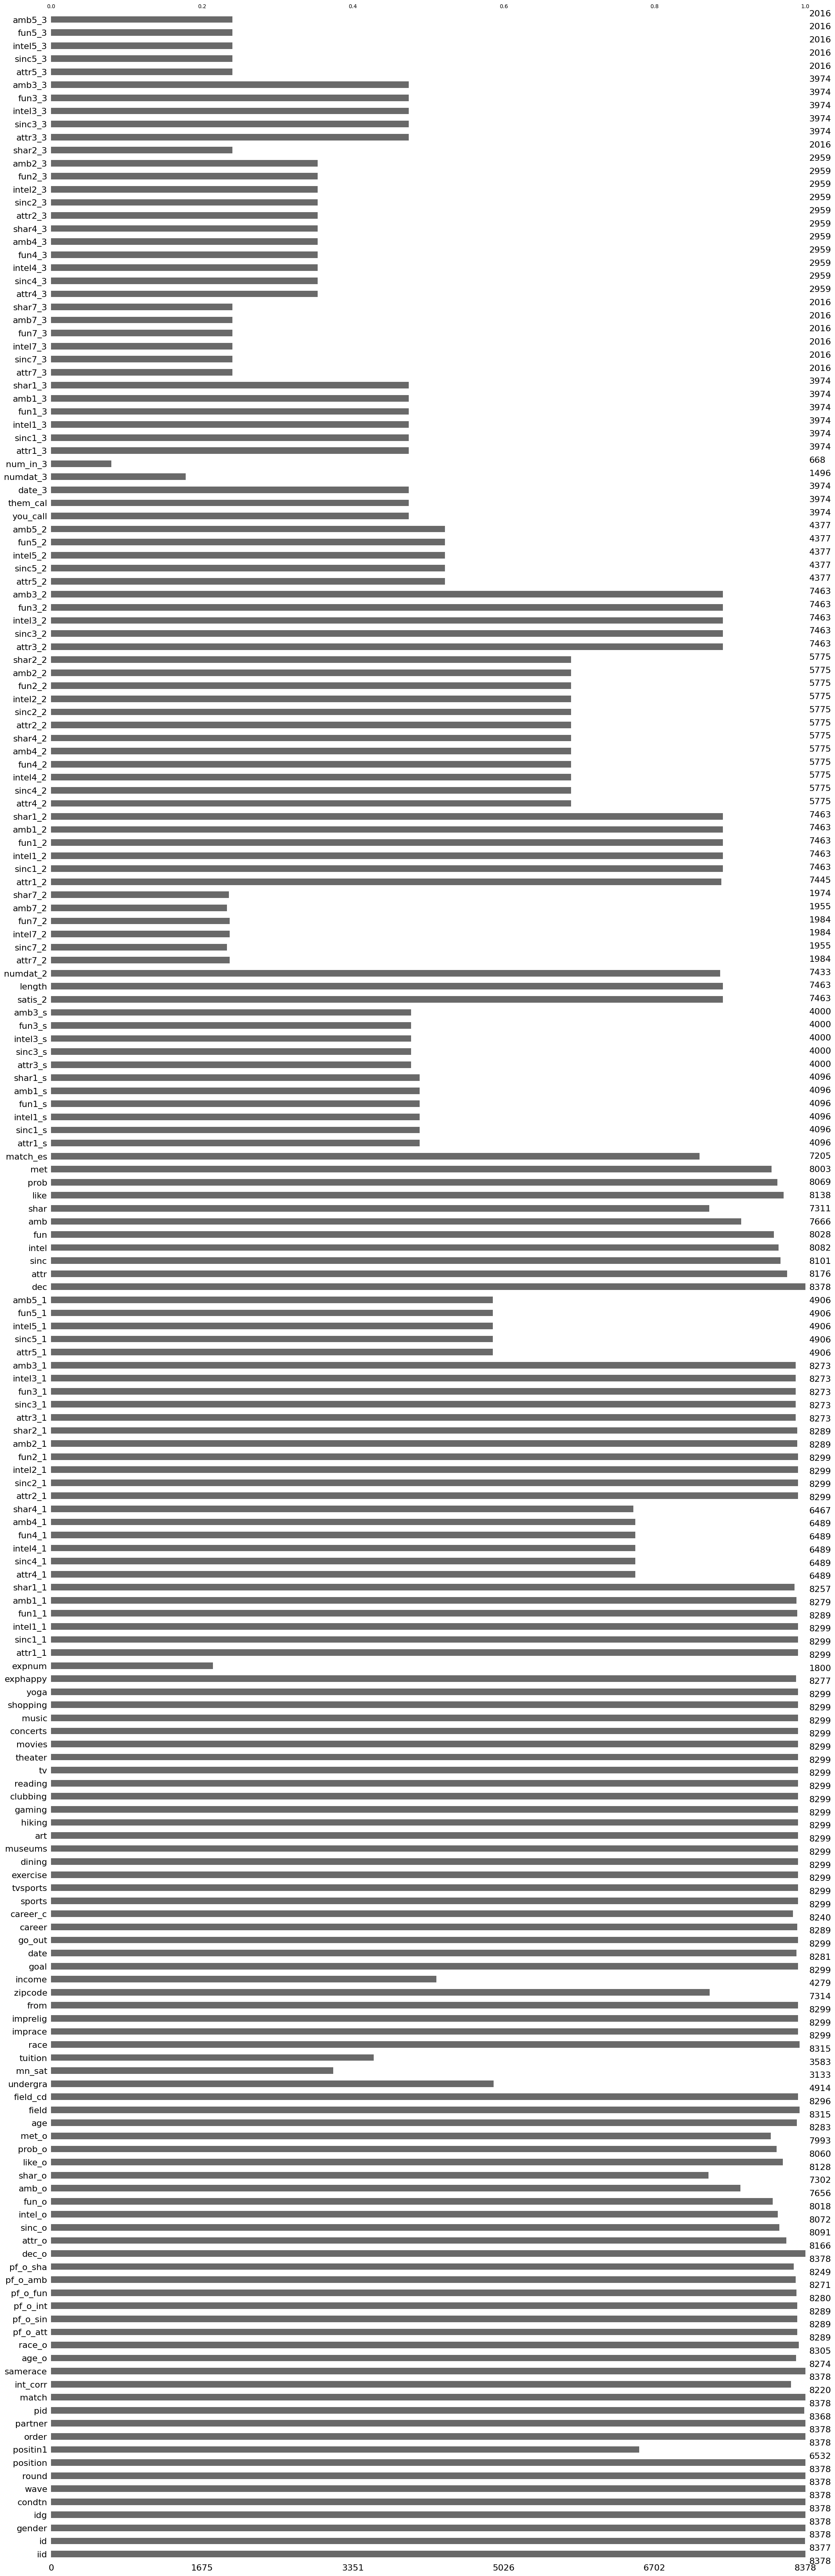

In [138]:
msno.bar(speed_dating_df)

In [139]:
print("null IID: ", speed_dating_df["iid"].isna().sum())
print("null PID: ", speed_dating_df["pid"].isna().sum())

null IID:  0
null PID:  10


Les 10 PID nulls sont un problème vu que le date est fait d'un couple (IID, PID).
Il faudra voir si on peut le fixer, sinon il faudra nettoyer ces lignes, voir ignorer la vague!

#### Valeurs manquantes pour les groupes d'attributs (phase/question)

In [140]:
# Quantifying missing score for attributes data per phase (whatever the question related perspective)
# a bundle of attributes is null only if all attributes are null as it is a distribtion of points over the attributes, thus some may have no value at all

phases = {
    "1": "Inscription",
    "s": "Mi parcours",
    "2": "Lendemain",
    "3": "Quelques semaines"
}

perspectives = {
  "1": "Ce que est important pour vous chez un partenaire",
  "2": "Perception de ce que le sexe opposé recherche",
  "3": "Auto-évaluation",
  "4": "Perception de ce que la plupart des personnes du même sexe recherchent",
  "5": "Perception de comment les autres vous perçoivent",
  "7": "Importance réelle dans les décisions",
}

null_attributes_wide_df = pd.DataFrame()

# Compute null flags
for p in phases:
    for q in perspectives:
        suffix = f"{q}_{p}"
        
        cols = [col for col in speed_dating_df.columns if col.endswith(suffix)]
        
        if len(cols) > 0:
            is_null_col = f"is_null_{suffix}"
            null_attributes_wide_df[is_null_col] = speed_dating_df[cols].isnull().all(axis=1)

null_attributes_df = null_attributes_wide_df.sum().to_frame().reset_index()
null_attributes_df.columns = ["attribute", "null_count"]

# Add readable attribut descriptions
def get_attribute_parameters(attribute):
    pattern = r"is_null_(\d+)_([A-Za-z0-9]+)"

    match = re.match(pattern, attribute)
    if match:
        q = match.group(1)
        p = match.group(2)

        return (p, q)
    
    return None

def get_phase_name(attribute):
    p = get_attribute_parameters(attribute)
    
    if p:
        return phases[str(p[0])]

    return "N/A"

def get_perspective_name(attribute):
    p = get_attribute_parameters(attribute)
    
    if p:
        return perspectives[str(p[1])]
    
    return "N/A"


null_attributes_df["phase"] = null_attributes_df["attribute"].map(get_phase_name)
null_attributes_df["perspective"] = null_attributes_df["attribute"].map(get_perspective_name)
null_attributes_df["proportion_of_null"] = round(100 * null_attributes_df["null_count"] / len(speed_dating_df), 2)

null_attributes_df.sort_values(by="null_count", ascending=False, inplace=True)

# Visualize ordered stats
display(null_attributes_df)

,attribute,null_count,phase,perspective,proportion_of_null
12,is_null_7_2,6394,Lendemain,Importance réelle dans les décisions,76.32
18,is_null_7_3,6362,Quelques semaines,Importance réelle dans les décisions,75.94
17,is_null_5_3,6362,Quelques semaines,Perception de comment les autres vous perçoivent,75.94
16,is_null_4_3,5419,Quelques semaines,Perception de ce que la plupart des personnes du même sexe recherchent,64.68
14,is_null_2_3,5419,Quelques semaines,Perception de ce que le sexe opposé recherche,64.68
15,is_null_3_3,4404,Quelques semaines,Auto-évaluation,52.57
13,is_null_1_3,4404,Quelques semaines,Ce que est important pour vous chez un partenaire,52.57
6,is_null_3_s,4378,Mi parcours,Auto-évaluation,52.26
5,is_null_1_s,4282,Mi parcours,Ce que est important pour vous chez un partenaire,51.11
11,is_null_5_2,4001,Lendemain,Perception de comment les autres vous perçoivent,47.76


#### Contrôle des notations apportées aux différents attributs par phase/question
Pour les préferences dont l'échelle de notation varie, on va vérifier ce qu'il en est.
D'aprés la documentation on devrait observer différentes échelles de valeurs sur les blocs suivant:
- attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1
- attr4_1, sinc4_1, intel4_1, fun4_1, amb4_1, shar4_1
- attr2_1, sinc2_1, int2_1, fun2_1, amb2_1, shar2_1
- attr1_2, sinc1_2, intel1_2, fun1_2, amb1_2, shar1_2

In [141]:
def has_outofbound_preference_scores(df, columns):
    # sum is less than 90 (need tolerance)
    under_90_mask = speed_dating_df[columns].sum(axis=1) < 90

    # All columns are empty
    # not_na_mask = not speed_dating_df[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].isnull().all(axis=1)
    not_na_mask = speed_dating_df[columns].notnull().any(axis=1)

    # print(speed_dating_df.shape)
    return len(speed_dating_df[not_na_mask & under_90_mask]) > 0

for p in [pref_1_1_cols, pref_4_1_cols, pref_2_1_cols, pref_1_2_cols]:
    if has_outofbound_preference_scores(speed_dating_df, p):
        print(p)

['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
['attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2', 'shar1_2']


Au final, il semblerait que les notes issues du questionnaire d'inscription aient été normalisées!

### Notes sur l'exploration initiale
- Comme anticipé à la lecture de la description des colonnes, beaucoup de valeurs manquantes dans les notations des préférences au niveau des différents attributs
- Il est probable que les candidats se désinteressent au fil du temps et ne répondent plus, en effet il y a moins de 50% de réponses en phase 3 (3 à 4 semaines aprés le speed-dating)
- Il est aussi probable que seuls les candidats ayant eu de nouvelles rencontres depuis le speed-dating avec leur match aient répondu au follow-up 3
- La target `match` est toujours remplie
- Beaucoup de type en float au lieu de int (pas bien grave mais on peut le corriger sans influer sur le dataset)
- lorsque les données manquantes correspondent à une donnée catégorielle ayant un `Other` on pourrait le choisir comme valeur par défaut